In [1]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
from torch.nn import Module, Parameter
from torch import FloatTensor
from scipy import signal
import numpy as np
from torchaudio import transforms
import matplotlib.pyplot as plt
import IPython.display as ipd
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
from scipy import signal
import numpy as np
from pylab import *
import soundfile as sf
import matplotlib.pyplot as plt

# Declare Model

In [2]:
class FIRNN(Module):
    def __init__(self, n_input=1, n_output=1, kernel_size=1000, n_channel=32):
        super(FIRNN, self).__init__()        
        self.conv_kz = kernel_size
        self.input_len = 20000
        self.conv1 = nn.Conv1d(n_input, 1, kernel_size=kernel_size, stride=1)
        self.nonlinear = nn.Tanh()
        self.bn1 = nn.BatchNorm1d(n_channel)

        self.fc1 = nn.Conv1d(1, n_channel*2, kernel_size=1) 
        self.fc2 = nn.Conv1d(n_channel*2, 1, kernel_size=1)
        
        self.conv2 = nn.Conv1d(1, 1, kernel_size=kernel_size, stride=1)
        
        self.mlp_layer = nn.Sequential(
            self.fc1 ,
            nn.Tanh(),
            self.fc2,
        )


    def forward(self, x):
        #print(x.shape)
        bs = x.shape[0]
        
        x = F.pad(x, (self.conv_kz-1, 0)) #pad on the left side
        x = self.conv1(x) 
        #print(x.shape)
        #x = self.nonlinear(self.bn1(x))
        #print(x.shape)

        #x = x.view(bs, -1)
        x = self.mlp_layer(x)
        #x = self.layers(x)
        #print(x.shape)
        
        x = F.pad(x, (self.conv_kz-1, 0))
        x = self.conv2(x)
        #print(x.shape)

        return x


In [21]:
class DIIRDataSet(Dataset):
    def __init__(self, input, target, sequence_length):
        self.input = input
        self.target = target
        self._sequence_length = sequence_length
        self.input_sequence = self.wrap_to_sequences(self.input, self._sequence_length)
        self.target_sequence = self.wrap_to_sequences(self.target, self._sequence_length)
        self._len = self.input_sequence.shape[0]

    def __len__(self):
        return self._len

    def __getitem__(self, index):
        return {'input': self.input_sequence[index, :, :]
               ,'target': self.target_sequence[index, :, :]}

    def wrap_to_sequences(self, data, sequence_length):
        num_sequences = int(np.floor(data.shape[0] / sequence_length))
        print(num_sequences)
        truncated_data = data[0:(num_sequences * sequence_length)]
        wrapped_data = truncated_data.reshape((num_sequences, sequence_length, 1))
        wrapped_data = wrapped_data.permute(0,2,1)
        print(wrapped_data.shape)
        return np.float32(wrapped_data)

    

# Evaluate

In [35]:
model = FIRNN(kernel_size=1000, n_channel=32)

In [36]:
model_path = './models/model_fir_pure.pth'
model.load_state_dict(torch.load(model_path))
model.eval()

FIRNN(
  (conv1): Conv1d(1, 1, kernel_size=(1000,), stride=(1,))
  (nonlinear): Tanh()
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
  (fc2): Conv1d(64, 1, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(1, 1, kernel_size=(1000,), stride=(1,))
  (mlp_layer): Sequential(
    (0): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
    (1): Tanh()
    (2): Conv1d(64, 1, kernel_size=(1,), stride=(1,))
  )
)

## Test on a sinusoidal signal

In [37]:
np.random.seed(0)

dt = 0.01  # sampling interval
Fs = 1 / dt  # sampling frequency
t = np.arange(0, 200, dt)

# generate noise:
nse = np.random.randn(len(t))
r = np.exp(-t / 0.05)
cnse = np.convolve(nse, r) * dt
cnse = cnse[:len(t)]

#s = 0.1 * np.sin(4 * np.pi * t) + cnse  # the signal
f = 1245
s = np.sin(2 * np.pi * f * t)

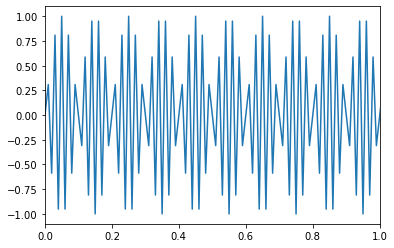

In [39]:
plt.plot(t,s)
plt.xlim(0,1)
plt.show()

In [40]:
sinput = torch.from_numpy(s).unsqueeze(0)

In [41]:
sinput.shape

torch.Size([1, 20000])

In [42]:
val_dataset=DIIRDataSet(sinput.squeeze(0), sinput.squeeze(0), 20000)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle = False, pin_memory=True, drop_last=True)

1
torch.Size([1, 1, 20000])
1
torch.Size([1, 1, 20000])


In [43]:
save_tensor = torch.zeros(1,20000)
with torch.no_grad():
    for i, val_batch in enumerate(val_loader):
        input_seq_batch = val_batch['input']
        predicted_output = model(input_seq_batch)
        output_tmp = predicted_output.squeeze().detach().cpu()
        #print(output_tmp.shape)
        save_tensor[i,:] = output_tmp

In [44]:
soutput = save_tensor.view(-1).numpy()

In [45]:
soutput.shape

(20000,)

### Compare the Spectrum on raw signal and distorted signal

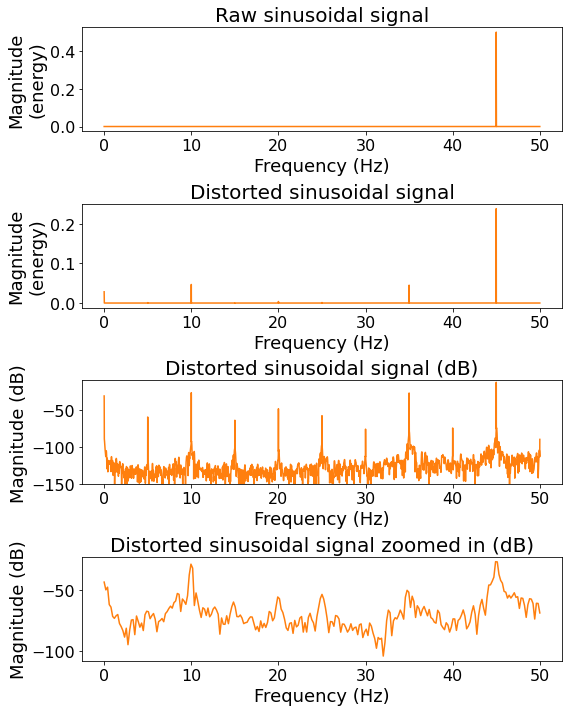

In [109]:
plt.figure(figsize=(8,10))
plt.subplot(4,1,1)
title("Raw sinusoidal signal", fontsize=20)
plt.magnitude_spectrum(s, Fs=1 / dt, color='C1')
plt.ylabel('Magnitude\n(energy)', fontsize=18)
plt.xlabel('Frequency (Hz)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)

plt.subplot(4,1,2)
title("Distorted sinusoidal signal", fontsize=20)
plt.magnitude_spectrum(soutput, Fs=1 / dt, color='C1')
plt.ylabel('Magnitude\n(energy)', fontsize=18)
plt.xlabel('Frequency (Hz)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)


plt.subplot(4,1,3)
title("Distorted sinusoidal signal (dB)", fontsize=20)
plt.magnitude_spectrum(soutput, Fs=Fs, scale='dB', color='C1')
plt.ylabel('Magnitude (dB)', fontsize=18)
plt.xlabel('Frequency (Hz)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylim(-150, -10)

plt.subplot(4,1,4)
title("Distorted sinusoidal signal zoomed in (dB)", fontsize=20)
plt.magnitude_spectrum(soutput[:512], Fs=Fs, scale='dB', color='C1')
plt.ylabel('Magnitude (dB)', fontsize=18)
plt.xlabel('Frequency (Hz)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
subplots_adjust(hspace=0.7)
plt.savefig('./figures/FIRNN_pure_sin_signal_spectrums.png', dpi=150)
plt.show()

### Get the convolution layer weights & average across channel dim (if

In [86]:
fir_weights = model.conv1.weight.detach().cpu().squeeze(1).numpy()
#fir_coefs = np.mean(fir_weights,0)

In [87]:
fir_weights.shape

(1, 1000)

In [88]:
fir_coefs = np.flip(fir_weights[0])

# Plot frequency response of the first "FIR" filter

In [79]:
def freq_plot(b, a=1):
    w,h = signal.freqz(b,a)
    nyq_rate = 44100/2
    #print(len(w))
    h_dB = 20 * np.log10 (abs(h))
    
    #plt.plot(w/max(w), h_dB, linewidth=2)
    plt.plot((w/np.pi)*nyq_rate,h_dB, linewidth=2)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain (dB)')
    plt.title('Frequency Response')
    plt.ylim(-80, 20)
    plt.grid(alpha=0.4)
    #plt.savefig('Frequency_response_1conv.png', dpi=150)
    plt.show()

def phase_plot(b, a=1):
    w,h = signal.freqz(b,a)
    nyq_rate = 44100/2
    h_Phase = unwrap(arctan2(imag(h),real(h)))
    
    #plt.plot(w/max(w), h_Phase, c='orange')
    plt.plot((w/np.pi)*nyq_rate,h_Phase, c='orange')
    plt.ylabel('Phase (radians)')
    plt.xlabel(r'Frequency (Hz)')
    plt.title(r'Phase response')
    plt.grid(alpha=0.4)
    #plt.savefig('Phase_response_1conv.png', dpi=150)
    plt.show()

In [80]:
#Plot impulse response
def impz(b,a=1):
    l = len(b)
    impulse = repeat(0.,l); impulse[0] =1.
    x = arange(0,l)
    response = signal.lfilter(b,1,impulse)
    plt.stem(x, response)
    plt.grid(alpha=0.4)
    ylabel('Amplitude')
    xlabel(r'n (samples)')
    title(r'Impulse response')
    #plt.savefig('impulse_response_1conv.png', dpi=150)

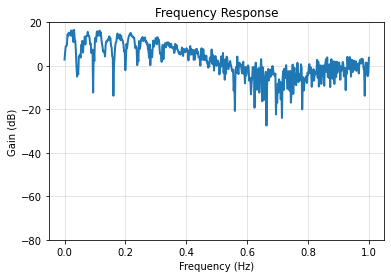

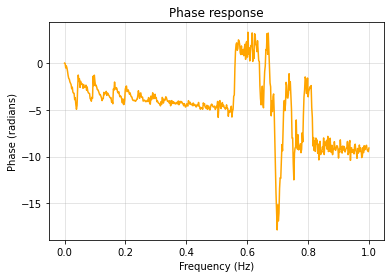

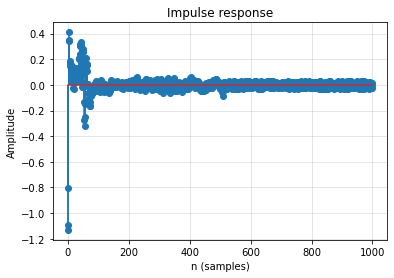

In [81]:
freq_plot(fir_coefs)
phase_plot(fir_coefs)
impz(fir_coefs)

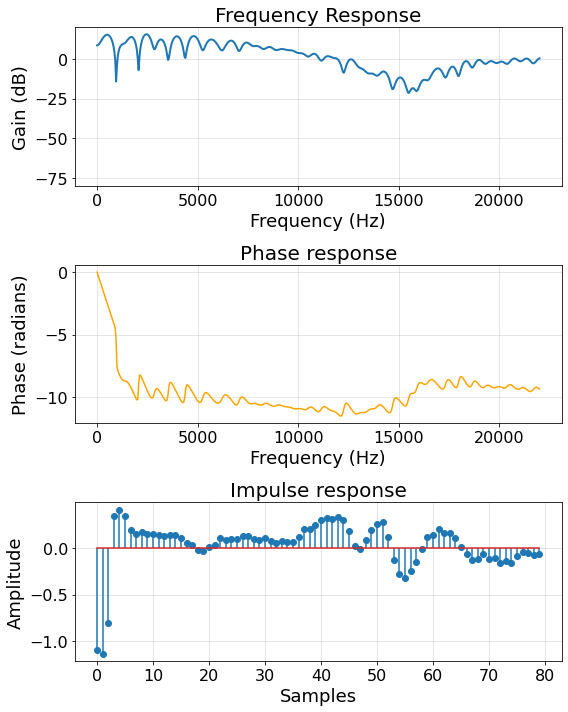

In [104]:
b = fir_coefs#[:80]
a = 1
w,h = signal.freqz(b,a)
nyq_rate = 44100/2
h_dB = 20 * np.log10 (abs(h))
h_Phase = unwrap(arctan2(imag(h),real(h)))


plt.figure(figsize=(8,10))

plt.subplot(3,1,1)
#plt.plot(w/max(w), h_dB, linewidth=2)
plt.plot((w/np.pi)*nyq_rate,h_dB, linewidth=2)
plt.xlabel('Frequency (Hz)', fontsize=18)
plt.ylabel('Gain (dB)', fontsize=18)
plt.title('Frequency Response', fontsize=20)
plt.ylim(-80, 20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.grid(alpha=0.4)
#plt.savefig('Frequency_response_1conv.png', dpi=150)

plt.subplot(3,1,2)
#plt.plot(w/max(w), h_Phase, c='orange')
plt.plot((w/np.pi)*nyq_rate,h_Phase, c='orange')
plt.ylabel('Phase (radians)', fontsize=18)
plt.xlabel(r'Frequency (Hz)', fontsize=18)
plt.title(r'Phase response', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.grid(alpha=0.4)
#plt.savefig('Phase_response_1conv.png', dpi=150)


l = len(b)
impulse = repeat(0.,l); impulse[0] =1.
x = arange(0,l)
response = signal.lfilter(b,1,impulse)
plt.subplot(3,1,3)
plt.stem(x, response)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.grid(alpha=0.4)
plt.ylabel('Amplitude', fontsize=18)
plt.xlabel(r'Samples', fontsize=18)
plt.title(r'Impulse response', fontsize=20)
#plt.savefig('impulse_response_1conv.png', dpi=150)

plt.tight_layout()
subplots_adjust(hspace=0.5)
plt.savefig('./figures/FIRNN_pure_freqresp_ph_imp_ord80.png', dpi=150)
plt.show()

## Import input & output audios

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device=", device) 

device= cpu


In [111]:
train_data_dir = './data/train'
val_data_dir = './data/val'
input_name = 'ht1-input.wav'
target_name = 'ht1-target.wav'
train_sig, _ = torchaudio.load(os.path.join(train_data_dir, input_name))
val_sig, sr = torchaudio.load(os.path.join(val_data_dir, input_name))
train_target_sig, _ = torchaudio.load(os.path.join(train_data_dir, target_name))
val_target_sig, _ = torchaudio.load(os.path.join(val_data_dir, target_name))
print(sr)

44100


In [112]:
train_input_seg = train_sig[:,:44100*60]
train_target_seg = train_target_sig[:,:44100*60]

In [188]:
out_path = './output/target_firnl_mlp_fir_preamph.wav'
distort_sig, _ = torchaudio.load(out_path)

## Plot spectrogram, waveform

In [126]:
def plot_waveform(waveform, sample_rate, title="Waveform of HT-1 distorted signal", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate
    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
    if xlim:
        axes[c].set_xlim(xlim)
    if ylim:
        axes[c].set_ylim(ylim)
    figure.suptitle(title, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=16)
    ylabel('Amplitude', fontsize=18)
    xlabel('Time', fontsize=18)
    plt.grid(alpha=0.4)
    plt.tight_layout()
    plt.savefig('./figures/'+title+'.png', dpi=150)
    plt.show(block=False)



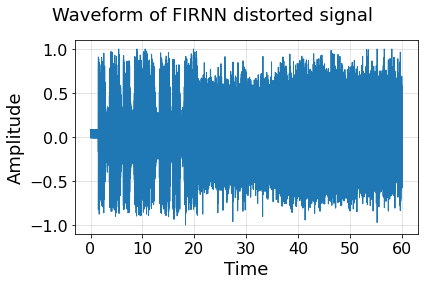

In [127]:
plot_waveform(distort_sig, sr, title="Waveform of FIRNN distorted signal")

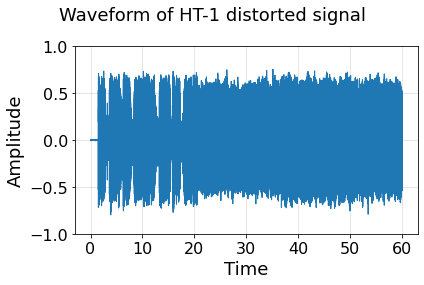

In [128]:
plot_waveform(train_target_seg, sr, title="Waveform of HT-1 distorted signal", ylim=(-1.0,1.0))

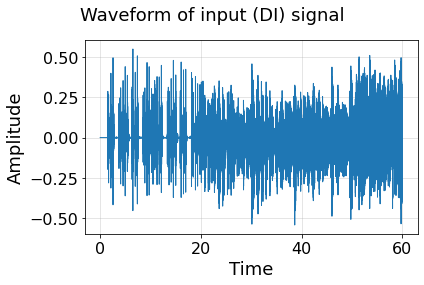

In [129]:
plot_waveform(train_input_seg, sr, title="Waveform of input (DI) signal")

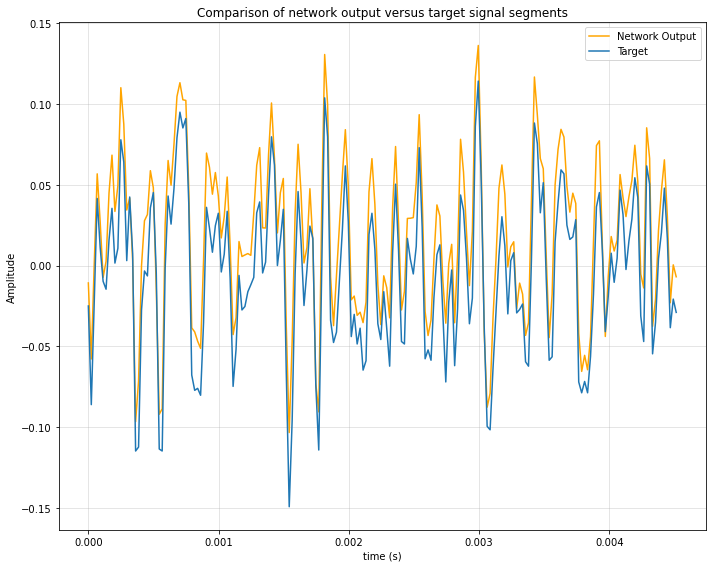

In [75]:
nn_out = distort_sig.squeeze()[44100*3:44100*3+200].numpy()
target = train_target_seg.squeeze()[44100*3:44100*3+200].numpy()

sample_rate = 44100

num_frames = nn_out.shape[0]
time_axis = np.arange(0, num_frames) / sample_rate

plt.figure(figsize=(10,8))
plt.plot(time_axis, nn_out, c='orange',linewidth=1.8)
plt.plot(time_axis, target,linewidth=1.5)
plt.grid(alpha=0.4)
ylabel('Amplitude', fontsize=18)
xlabel('Time (s)', fontsize=18)
title(r'Waveforms of a guitar sound processed by HT-1 and the FIRNN', fontsize=18)
legend(['Network Output', 'Target'])
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
#plt.savefig('./figures/waveform_cmp_nnout_target.png', dpi=150)

In [132]:
def plot_specgram(waveform, sample_rate, title="Spectrogram of HT-1 distorted Signal", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
        axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
        axes[c].set_xlim(xlim)
    figure.suptitle(title, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=16)
    ylabel('Frequency', fontsize=18)
    xlabel('Time', fontsize=18)
    plt.tight_layout()
    plt.savefig('./figures/'+title+'.png', dpi=150)
    plt.show(block=False)

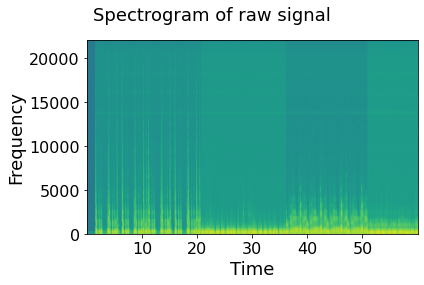

In [138]:
plot_specgram(train_input_seg, sr, title='Spectrogram of raw signal')

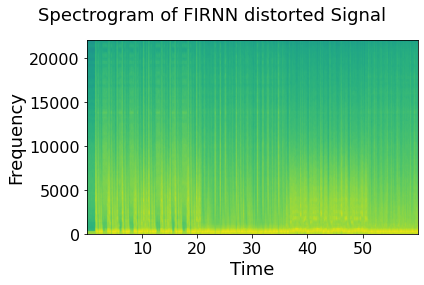

In [136]:
plot_specgram(distort_sig, sr, title='Spectrogram of FIRNN distorted Signal')

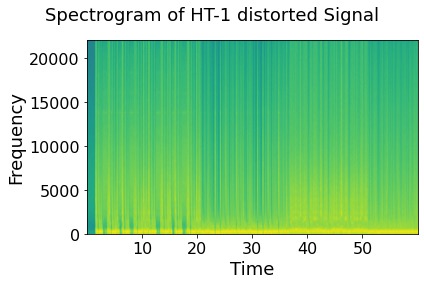

In [139]:
plot_specgram(train_target_seg, sr, title='Spectrogram of HT-1 distorted Signal')

# Plot Spectrum (log) here

In [140]:
train_data_dir = './data/train'
val_data_dir = './data/val'
input_name = 'ht1-input.wav'
target_name = 'ht1-target.wav'
train_sig, _ = torchaudio.load(os.path.join(train_data_dir, input_name))
val_sig, sr = torchaudio.load(os.path.join(val_data_dir, input_name))
train_target_sig, _ = torchaudio.load(os.path.join(train_data_dir, target_name))
val_target_sig, _ = torchaudio.load(os.path.join(val_data_dir, target_name))
print(sr)

44100


In [141]:
out_path = './output/target_firnl_mlp_fir_preamph.wav'
distort_sig, _ = torchaudio.load(out_path)

In [191]:
train_input_seg = train_sig[:,44100*3:44100*4].squeeze().numpy()
train_target_seg = train_target_sig[:,44100*3:44100*4].squeeze().numpy()
distort_seg = distort_sig[:,44100*3:44100*4].squeeze().numpy()

In [205]:
s = distort_seg

In [200]:
s.shape

(44100,)

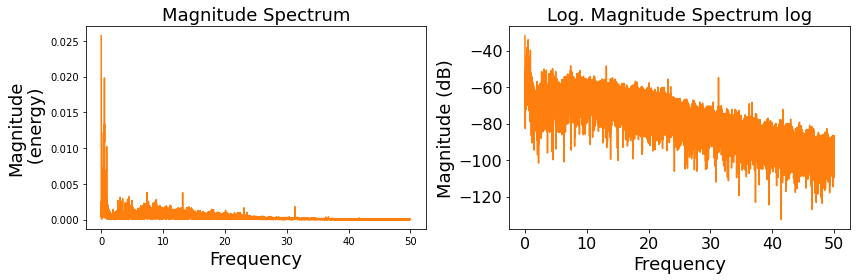

In [206]:
# plot time signal:
plt.figure(figsize=(12,4))
#fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

# plot different spectrum types:
plt.subplot(1,2,1)
title("Magnitude Spectrum", fontsize=18)
plt.magnitude_spectrum(s, Fs=Fs, color='C1')
plt.ylabel('Magnitude\n (energy)', fontsize=18)
plt.xlabel(r'Frequency', fontsize=18)

plt.subplot(1,2,2)
title("Log. Magnitude Spectrum log", fontsize=18)
plt.magnitude_spectrum(s, Fs=Fs, scale='dB', color='C1')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('Magnitude (dB)', fontsize=18)
plt.xlabel(r'Frequency', fontsize=18)

fig.tight_layout()
subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.savefig('./figures/firnn_spectrum.png', dpi=150)
plt.show()